In [1]:
# # header
import sys
sys.path.append(r"../")

%load_ext autoreload
%autoreload 2

In [2]:
# # built-in modules
import os
import time
# # Torch modules
import torch
import torchvision
# # internal imports
from prelude import load_dicts, get_device
from src.modelv2 import AttentionModel
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from torchvision import transforms
# other imports
import seaborn as sns
import numpy
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit


In [3]:
# auxiliary functions
# # circular gaussian functions
def circ_gaus_1(x, C, Rp, Po, Sd):
    return C + Rp * numpy.exp(-0.5 * ((numpy.sin((x - Po)/2.0) / Sd) ** 2))
def circ_gaus_2(x, C, Rp, Po, Sd):
    return C + Rp * numpy.exp(-0.5 * ((numpy.sin(x - Po) / Sd) ** 2))
def circ_gaus_4(x, C, Rp, Po, Sd):
    return C + Rp * numpy.exp(-0.5 * ((numpy.sin(2.0*(x - Po)) / Sd) ** 2))

# # euclidean distance
def euclidean_distance(x1, x2):
    return torch.sqrt(torch.sum((x1 - x2) ** 2))

# # fitting circular gaussian functions
def fit_circ_gaus(x, y, n=1):
    C, Rp, Po, Sd = y.min(), y.max(), x[y.argmax()], 1.0
    bounds = ((-100.0, -100.0, 1e-6, 1e-6), (100.0, 100.0, 4*numpy.pi, (4*numpy.pi)**2))
    # bounds = ((-100.0, -100.0, 1e-6, 1e-6), (100.0, 100.0, numpy.inf, numpy.inf))
    if n == 1:
        popt, pcov = curve_fit(circ_gaus_1, x, y, p0=[C, Rp, Po, Sd], bounds=bounds)
        y_circ = torch.tensor(circ_gaus_1(x, *popt))
    elif n == 2:
        popt, pcov = curve_fit(circ_gaus_2, x, y, p0=[C, Rp, Po, Sd], bounds=bounds)
        y_circ = torch.tensor(circ_gaus_2(x, *popt))
    elif n == 4:
        popt, pcov = curve_fit(circ_gaus_4, x, y, p0=[C, Rp, Po, Sd], bounds=bounds)
        y_circ = torch.tensor(circ_gaus_4(x, *popt))
    return popt, y_circ

# # choose the best fit
def choose_better_fit(x, y):
    rec = []
    for n in (1, 2, 4):
        try:
            popt, y_circ = fit_circ_gaus(x, y, n)
            y_circ_d = euclidean_distance(y, y_circ)
        except:
            popt, y_circ, y_circ_d = (None, None, None, None), None, 1e6
        rec.append((popt, y_circ, y_circ_d, n))
    if rec[0][2] < rec[1][2] and rec[0][2] < rec[2][2]:
        return rec[0]
    elif rec[1][2] < rec[0][2] and rec[1][2] < rec[2][2]:
        return rec[1]
    else:
        return rec[2]
    
# # plot polar graphs
def plot_polar(x, Ys, set_lims=False, save_path=None, title=None):
    colors = ['red', 'blue', 'magenta', 'cyan']
    linestyles = ['solid', 'solid', "dotted", "dotted"]
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.5)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_title(title) if title is not None else None
    for i, Y in enumerate(Ys):
        ax.plot(x*torch.pi/180.0, Y, color=colors[i], linestyle=linestyles[i])
    if set_lims:
        ax.set_rmax(1.0)
        ax.set_rmin(-1.0)
        ax.set_rticks([-1.0, -0.5, 0.0, 0.5, 1.0])  # Less radial ticks
    if save_path is not None:
        plt.savefig(save_path, format='svg')
        plt.close()
    else:
        plt.show()

In [4]:
# model and optimizer...
start_folder = r"../pretrained/shapes"
results_folder = os.path.join(start_folder, f"{int(time.time())}")
os.makedirs(results_folder)
print(f"Results will be saved in {results_folder}")
data_path = r"../data"
DeVice, num_workers, pin_memory = get_device()
model_params = load_dicts(start_folder, "model_params")
model = AttentionModel(**model_params)
model_dir = os.path.join(start_folder, "model" + ".pth")
assert os.path.exists(model_dir), "Could not find the model.pth in the given dir!"
model.load_state_dict(torch.load(model_dir, map_location=DeVice))

Results will be saved in ../pretrained/shapes/1753607177
Device set to mps


<All keys matched successfully>

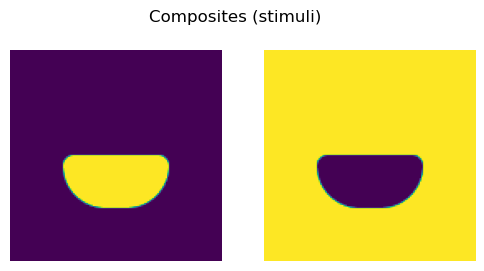

In [5]:
call_png = True
if call_png:
    a = r"/Users/saeedida/GitProjects/bio-attention/data/squares"
    x_0 = 1.0 * (transforms.ToTensor()(PILImage.open(os.path.join(a, "rsvp.png")))[2]).unsqueeze(0)
else:
    mid, width, hwidth = 64, 48, 24
    x_0 = torch.zeros(1, 128, 128)
    x_0[0, mid:mid+width, mid-hwidth:mid+hwidth] = 1.0

composites_0 = x_0.unsqueeze(0)
composites_i = (1.0 - x_0).unsqueeze(0)
plt.figure(figsize=(6, 3))
plt.suptitle("Composites (stimuli)")
plt.subplot(1, 2, 1)
plt.imshow(composites_0[0].permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(composites_i[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

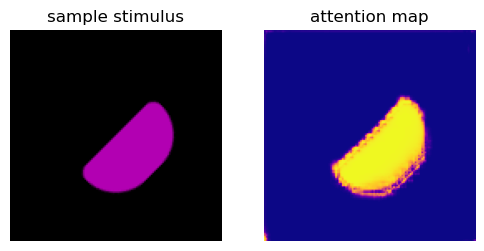

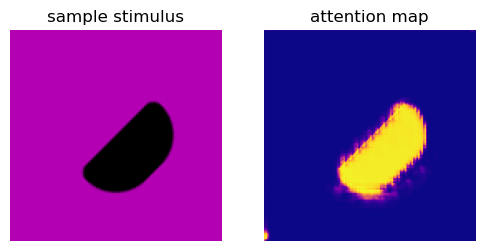

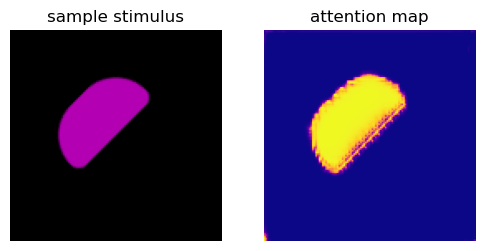

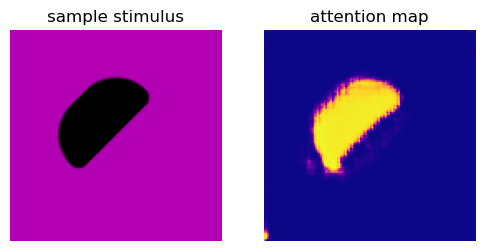

In [6]:
model.to(DeVice)
model.eval()
for r in (45, 225):
    for invert in (False, True):
        interpol = torchvision.transforms.InterpolationMode.BILINEAR
        color = torch.tensor([0.7, 0.0, 0.7]).view(1, 3, 1, 1)
        with torch.no_grad():
            composites = torchvision.transforms.functional.rotate(composites_0, r, interpolation=interpol)
            composites = (1.0 - composites) if invert else composites
            composites = composites * color
            masks_, labels_, act_ = model.forward(composites.unsqueeze(0).to(DeVice))
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.title("sample stimulus")
        plt.imshow(composites[0].permute(1, 2, 0))
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.title("attention map")
        plt.imshow(masks_[0, 0, 0].detach().cpu(), cmap='plasma')
        plt.axis('off')
        plt.savefig(os.path.join(results_folder, f"mask_{'i' if invert else '0'}_{r}.svg"), format='svg')
        plt.show()

In [7]:
acts_0 = []
masks_0 = []
acts_i = []
masks_i = []
theta_list = list(range(0, 361, 1))
theta = torch.tensor(theta_list)
model.to(DeVice)
model.eval()
with torch.no_grad():
    for invert in [False, True]:
        for r in theta_list:
            composites = torchvision.transforms.functional.rotate(composites_0, r, interpolation=interpol)
            composites = (1.0 - composites) if invert else composites
            composites = composites * color
            masks_, labels_, act_ = model.forward(composites.unsqueeze(0).to(DeVice))
            (acts_i if invert else acts_0).append(act_[-2])
            (masks_i if invert else masks_0).append(model.masks['mask_3'])

masks_0 = torch.stack(masks_0, dim=0).detach().cpu()
acts_0 = torch.stack(acts_0, dim=0).detach().cpu()
masks_i = torch.stack(masks_i, dim=0).detach().cpu()
acts_i = torch.stack(acts_i, dim=0).detach().cpu()

In [8]:
prep = lambda x: torch.tensor(gaussian_filter1d(x.flatten(1).permute(1, 0).numpy(), 2, axis=1))
masks_0_rf = prep(masks_0[:, 0, :, 8:10, 8:10])
masks_i_rf = prep(masks_i[:, 0, :, 8:10, 8:10])
acts_0_rf = prep(acts_0[:, 0, 0, :, 8:10, 8:10])
acts_i_rf = prep(acts_i[:, 0, 0, :, 8:10, 8:10])
masks_0_rf_fitted = torch.zeros_like(masks_0_rf)
masks_i_rf_fitted = torch.zeros_like(masks_i_rf)
acts_0_rf_fitted = torch.zeros_like(acts_0_rf)
acts_i_rf_fitted = torch.zeros_like(acts_i_rf)

In [9]:
acts_acceptance = []
acts_popt = []
for i in range(acts_0_rf.size(0)):
    xdata = (theta*torch.pi/180.0).numpy()
    ploting = [acts_0_rf[i], acts_i_rf[i]]
    title = ""
    acts_popt.append([None, None])
    for j, ydata in enumerate([acts_0_rf[i], acts_i_rf[i]]):
        try:
            popt, yfit, _, n = choose_better_fit(xdata, ydata)
            title += f"{n}: {popt[-1]:.2f}  " if popt[-1] is not None else "None  "
            if yfit is not None:
                ploting.append(yfit)
                acts_popt[-1][j] = (*popt, n)
                if j == 0:
                    acts_0_rf_fitted[i] = yfit
                else:
                    acts_i_rf_fitted[i] = yfit
        except (RuntimeError, ValueError):
            pass
    acts_acceptance.append(i) if len(ploting) == 4 else None
    # file_loc = os.path.join(results_folder, f"acts_{i}.svg")
    # plot_polar(theta, ploting, set_lims=False, save_path=file_loc, title=title)

In [10]:
masks_acceptance = []
masks_popt = []
for i in range(masks_0_rf.size(0)):
    xdata = (theta*torch.pi/180.0).numpy()
    ploting = [masks_0_rf[i], masks_i_rf[i]]
    title = ""
    masks_popt.append([None, None])
    for j, ydata in enumerate([masks_0_rf[i], masks_i_rf[i]]):
        try:
            popt, yfit, _, n = choose_better_fit(xdata, ydata)
            title += f"{n}: {popt[-1]:.2f}  " if popt[-1] is not None else "None  "
            if yfit is not None:
                ploting.append(yfit)
                masks_popt[-1][j] = (*popt, n)
                if j == 0:
                    masks_0_rf_fitted[i] = yfit
                else:
                    masks_i_rf_fitted[i] = yfit
        except (RuntimeError, ValueError):
            pass
    masks_acceptance.append(i) if len(ploting) == 4 else None
    # file_loc = os.path.join(results_folder, f"masks_{i}.svg")
    # plot_polar(theta, ploting, set_lims=True, save_path=file_loc, title=title)

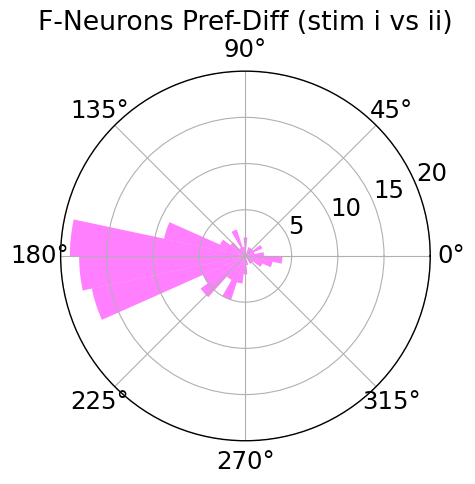

In [11]:
pref_diff = []
for i in acts_acceptance:
    off_0, amp_0, pref_0, std_0, n_0 = acts_popt[i][0]
    off_i, amp_i, pref_i, std_i, n_i = acts_popt[i][1]
    pref_diff.append((pref_0%(2*numpy.pi) - pref_i%(2*numpy.pi)))
pref_diff = torch.tensor(pref_diff)
pref_diff = pref_diff % (2*numpy.pi)
# median = pref_diff.median() * 180.0 / numpy.pi
sns.set_context("paper", font_scale=2.0)
bins = numpy.linspace(0, 2*numpy.pi, 31, endpoint=True)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.title(f"F-Neurons Pref-Diff (stim i vs ii)")
ax.hist(pref_diff, bins=bins, color='magenta', alpha=0.5)
ax.set_rmax(20)
ax.set_rmin(0)
plt.savefig(os.path.join(results_folder, "pref_diff_forward.svg"), format='svg')
plt.show()

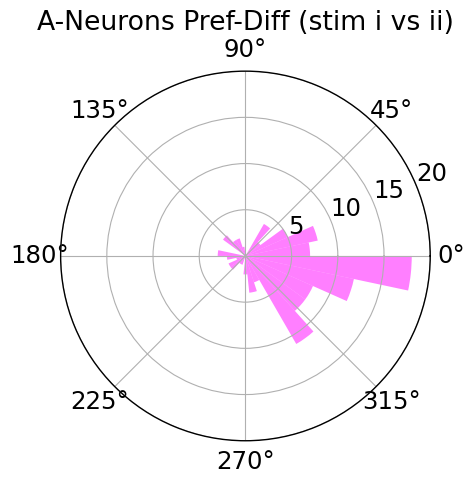

In [12]:
pref_diff = []
for i in masks_acceptance:
    off_0, amp_0, pref_0, std_0, n_0 = masks_popt[i][0]
    off_i, amp_i, pref_i, std_i, n_i = masks_popt[i][1]
    pref_diff.append((pref_0%(2*numpy.pi) - pref_i%(2*numpy.pi)))
pref_diff = torch.tensor(pref_diff)
pref_diff = pref_diff % (2*numpy.pi)
# median = pref_diff.median() * 180.0 / numpy.pi
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.title(f"A-Neurons Pref-Diff (stim i vs ii)")
bins = numpy.linspace(0, 2*numpy.pi, 31, endpoint=True)
ax.hist(pref_diff, bins=bins, color='magenta', alpha=0.5)
ax.set_rmax(20)
ax.set_rmin(0)
plt.savefig(os.path.join(results_folder, "pref_diff_backward.svg"), format='svg')
plt.show()

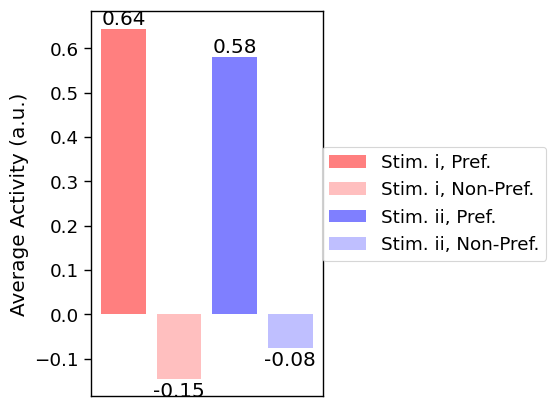

In [13]:
pref_pv = 0.0
pref_nv = 0.0
pref_pv_i = 0.0
pref_nv_i = 0.0
for i in masks_acceptance:
    off_0, amp_0, pref_0, std_0, n_0 = masks_popt[i][0]
    pref_p = masks_0_rf_fitted[i].argmax()
    nonpref_p = pref_p - (180 // n) if pref_p >= (180 // n) else pref_p + (180 // n)
    pref_pv += masks_0_rf_fitted[i][pref_p]
    pref_nv += masks_0_rf_fitted[i][nonpref_p]

    off_i, amp_i, pref_i, std_i, n_i = masks_popt[i][1]
    pref_p_i = masks_i_rf_fitted[i].argmax()
    nonpref_p_i = pref_p_i - (180 // n_i) if pref_p_i >= (180 // n_i) else pref_p_i + (180 // n_i)
    pref_pv_i += masks_i_rf_fitted[i][pref_p_i]
    pref_nv_i += masks_i_rf_fitted[i][nonpref_p_i]

pref_pv /= len(masks_acceptance)
pref_nv /= len(masks_acceptance)
pref_pv_i /= len(masks_acceptance)
pref_nv_i /= len(masks_acceptance)

sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(3, 5))
plt.bar([0], [pref_pv], color='red', alpha=0.5, label="Stim. i, Pref.")
plt.bar([1], [pref_nv], color='red', alpha=0.25, label="Stim. i, Non-Pref.")
plt.bar([2], [pref_pv_i], color='blue', alpha=0.5, label="Stim. ii, Pref.")
plt.bar([3], [pref_nv_i], color='blue', alpha=0.25, label="Stim. ii, Non-Pref.")
plt.text(0, pref_pv, f"{pref_pv:.2f}", ha='center', va='bottom')
plt.text(1, pref_nv-0.05, f"{pref_nv:.2f}", ha='center', va='bottom')
plt.text(2, pref_pv_i, f"{pref_pv_i:.2f}", ha='center', va='bottom')
plt.text(3, pref_nv_i-0.05, f"{pref_nv_i:.2f}", ha='center', va='bottom')
plt.legend(loc='right', bbox_to_anchor=(2.0, 0.5))
plt.xticks([])
plt.ylabel("Average Activity (a.u.)")
plt.savefig(os.path.join(results_folder, "pref_average_act.svg"), format='svg')
plt.show()